# LSTM

## Imports

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import optuna
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')

C:\Users\edupa\PycharmProjects\SP500-Using-ML-and-Search-Methods\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 ## Feature Engineering Functions
 This cell defines functions to compute various technical indicators and preprocess data:
 - `add_macd`: Computes the MACD (Moving Average Convergence Divergence) and its signal line.
   These indicators help capture momentum and trend reversals.
 - `add_bollinger_bands`: Computes Bollinger Bands, which indicate price volatility.
 - `create_technical_indicators`: Combines various indicators such as SMA, RSI, MACD, and Bollinger Bands
   into the dataset. It ensures all indicators are added and missing values are handled.
 - `create_sequences`: Converts time series data into sequences for LSTM input by slicing the data into
   overlapping windows based on the `look_back` period.
 - `mape`: Calculates Mean Absolute Percentage Error (MAPE) to evaluate prediction accuracy.
 - `build_lstm_model`: Defines an LSTM model with configurable units, dropout, and learning rate.
 - `generate_signal`: Generates buy/sell/hold signals based on predicted price changes exceeding a defined threshold.


In [3]:
def add_macd(df, short_window=12, long_window=26, signal_window=9):
    df['EMA_short'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['MACD_signal'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    df.drop(['EMA_short','EMA_long'], axis=1, inplace=True)
    return df

def add_bollinger_bands(df, n=20):
    df['BB_middle'] = df['Close'].rolling(n).mean()
    df['BB_std'] = df['Close'].rolling(n).std()
    df['BB_upper'] = df['BB_middle'] + 2 * df['BB_std']
    df['BB_lower'] = df['BB_middle'] - 2 * df['BB_std']
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

def create_technical_indicators(df):
    df = df.copy()
    df['Returns'] = df['Close'].pct_change()

    # SMAs
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()

    # RSI
    window_length = 14
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    roll_up = up.rolling(window_length).mean()
    roll_down = down.rolling(window_length).mean()
    RS = roll_up / (roll_down + 1e-9)
    df['RSI_14'] = 100.0 - (100.0/(1.0+RS))

    # MACD
    df = add_macd(df)

    # Bollinger Bands
    df = add_bollinger_bands(df)

    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    return df

def create_sequences(data, dates, look_back):
    X, y, y_dates = [], [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i])
        y.append(data[i, 0])  # first column is Close
        y_dates.append(dates[i])
    return np.array(X), np.array(y), y_dates

def mape(y_true, y_pred, eps=1e-9):
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

def build_lstm_model(input_shape, units=64, dropout=0.2, lr=1e-3):
    from keras.optimizers import Adam
    model = Sequential([
        LSTM(units=units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout),
        LSTM(units=units),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr))
    return model

def generate_signal(df, threshold=0.01):
    df = df.copy()
    df['next_day_prediction'] = df['prediction'].shift(-1)
    df['predicted_change'] = df['next_day_prediction'] - df['prediction']
    df['pct_change'] = df['predicted_change'] / (df['prediction'] + 1e-9)
    df['next_day_actual'] = df['actual'].shift(-1)

    def get_signal(row):
        if row['pct_change'] > threshold:
            return 'buy'
        elif row['pct_change'] < -threshold:
            return 'sell'
        else:
            return 'hold'

    df['signal'] = df.apply(get_signal, axis=1)
    df.dropna(subset=['next_day_prediction', 'next_day_actual'], inplace=True)
    return df[['date', 'signal', 'prediction', 'actual']]


## Define Parameters and Process Data

This section sets up the parameters for the data processing workflow. It defines a list of stock tickers, a uniform threshold for signal generation, and the date ranges for training, validation, and testing periods. Using the `yfinance` library, it then extracts historical price data and computes several technical indicators: Close, SMA_5, SMA_20, RSI_14, MACD, MACD_signal, BB_upper, BB_middle, BB_lower, and Volume. This ensures that we have a comprehensive feature set for subsequent model training and evaluation.


In [3]:
input_dir = 'clean_csvs'
tickers = [filename.replace('.csv', '') for filename in os.listdir(input_dir) if filename.endswith('.csv')]
print(tickers)
uniform_threshold = 0.01
train_end = "2022-12-31"
val_end = "2023-12-31"
test_start = "2024-01-01"
test_end = "2024-01-31"
start_date = "2010-01-01"

['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMTM', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBY', 'BDX', 'BEN', 'BF-B', 'BG', 'BIIB', 'BK', 'BKNG', 'BKR', 'BLDR', 'BLK', 'BMY', 'BR', 'BRK-B', 'BRO', 'BSX', 'BWA', 'BX', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CEG', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COR', 'COST', 'CPAY', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTLT', 'CTRA', 'CTSH', 'CTVA', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DAY', 'DD', 'DE', 'DECK', 'DELL', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS

In [5]:
def load_and_preprocess_data(ticker, start_date, val_end, test_end):
    # We load data up to test_end to have full picture
    data = yf.download(ticker, start=start_date, end=test_end)
    if data.empty:
        return None

    # Add technical indicators
    data = create_technical_indicators(data)

    # Include Volume as a feature
    # Feature order: Close (target), Returns, SMA_5, SMA_20, RSI_14, MACD, MACD_signal, BB_upper, BB_middle, BB_lower, Volume
    # Also ensure no missing values remain
    features = ['Close','Returns','SMA_5','SMA_20','RSI_14','MACD','MACD_signal','BB_upper','BB_middle','BB_lower','Volume']
    data = data[features].copy()
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)

    # Split into train/val/test based on date
    train_df = data.loc[:train_end]
    val_df = data.loc[train_end:val_end]
    test_df = data.loc[val_end:test_end]

    # If val or test are empty, return None
    if len(train_df) < 1 or len(val_df) < 1 or len(test_df) < 1:
        return None

    return train_df, val_df, test_df

# Finding Hyperparameter

This block employs the `Optuna` library to perform hyperparameter optimization for an LSTM model. It tunes key hyperparameters such as `look_back` (sequence length), the number of LSTM units, dropout rate, and learning rate. The `objective` function evaluates these hyperparameters by training the LSTM model on scaled training data and validating it on scaled validation data. Early stopping is implemented to prevent overfitting. The study runs for a specified number of trials (`n_trials`) to identify the best combination of hyperparameters that minimizes validation loss. The optimal hyperparameters are then displayed.

In [6]:
def objective(trial):
    # We'll run tuning on just one ticker or a subset due to time complexity.
    # Let's pick the first ticker for demonstration.
    ticker = tickers[0]
    data_sets = load_and_preprocess_data(ticker, start_date, val_end, test_end)
    if data_sets is None:
        # If no data or insufficient
        return float('inf')

    train_df, val_df, test_df = data_sets

    # Hyperparameters to tune
    look_back = trial.suggest_int('look_back', 10, 40)
    units = trial.suggest_categorical('units', [32,64,128])
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)

    # Scale data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(train_df)
    scaled_train = scaler.transform(train_df)
    scaled_val = scaler.transform(val_df)

    # Create sequences
    X_train, y_train, y_train_dates = create_sequences(scaled_train, train_df.index, look_back)
    X_val, y_val, y_val_dates = create_sequences(scaled_val, val_df.index, look_back)

    if X_train.size == 0 or X_val.size == 0:
        return float('inf')

    model = build_lstm_model((look_back, scaled_train.shape[1]), units=units, dropout=dropout, lr=lr)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop], verbose=0)
    val_loss = model.evaluate(X_val, y_val, verbose=0)
    return val_loss

print("Running Optuna optimization...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
best_params = study.best_params
print("Best hyperparameters found by Optuna:", best_params)

[I 2024-12-08 14:42:14,426] A new study created in memory with name: no-name-b7e26ffd-7e8e-4f51-ab30-94f3bb5b4ed1


Running Optuna optimization...


[*********************100%***********************]  1 of 1 completed
[I 2024-12-08 14:43:33,373] Trial 0 finished with value: 0.00037220766535028815 and parameters: {'look_back': 39, 'units': 128, 'dropout': 0.32625380642806084, 'lr': 0.0024773892081918062}. Best is trial 0 with value: 0.00037220766535028815.
[*********************100%***********************]  1 of 1 completed
[I 2024-12-08 14:43:47,135] Trial 1 finished with value: 0.0008901515393517911 and parameters: {'look_back': 12, 'units': 64, 'dropout': 0.3633247715904276, 'lr': 0.00019303770685056787}. Best is trial 0 with value: 0.00037220766535028815.
[*********************100%***********************]  1 of 1 completed
[I 2024-12-08 14:44:08,061] Trial 2 finished with value: 0.0006645835237577558 and parameters: {'look_back': 21, 'units': 64, 'dropout': 0.30719458947980793, 'lr': 0.0003489592651033886}. Best is trial 0 with value: 0.00037220766535028815.
[*********************100%***********************]  1 of 1 completed
[I

Best hyperparameters found by Optuna: {'look_back': 10, 'units': 64, 'dropout': 0.0028046361569943473, 'lr': 0.008353748196564433}


Define Parameters

## Final Training and Testing for Each Ticker

**Short Description:**

This block performs final training and testing of the LSTM model for each stock ticker using the best hyperparameters found during the Optuna optimization. Key steps include:

1. **Data Preparation**: Loads and preprocesses historical data, scaling features with `MinMaxScaler` and combining training and validation sets for final model training.

2. **Sequence Creation**: Generates input sequences for training and testing using a `look_back` window.

3. **Model Training**: Trains the LSTM model with early stopping to optimize performance while preventing overfitting.

4. **Predictions and Scaling**: Makes predictions for January 2024, scaling them back to the original range for evaluation.

5. **Signal Generation**: Creates trading signals (buy/sell/hold) based on predicted price movements for January 2024.

6. **Data Collection**: Stores predictions and signals in `all_predictions` and `all_signals` for each ticker for subsequent aggregation and analysis.

In [ ]:
all_signals = []
all_predictions = []

for ticker in tickers:
    print(f"\nFinal training with best params for {ticker}...")

    data_sets = load_and_preprocess_data(ticker, start_date, val_end, test_end)
    if data_sets is None:
        print(f"Skipping {ticker}: not enough data.")
        continue

    train_df, val_df, test_df = data_sets

    # Combine train and val for final training
    full_train_df = pd.concat([train_df, val_df])
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(full_train_df)
    scaled_full_train = scaler.transform(full_train_df)
    scaled_test = scaler.transform(test_df)

    look_back = best_params['look_back']
    units = best_params['units']
    dropout = best_params['dropout']
    lr = best_params['lr']

    X_full_train, y_full_train, y_full_dates = create_sequences(scaled_full_train, full_train_df.index, look_back)

    # Prepare test sequences (January 2024)
    # We need last `look_back` from full train+val to append test
    combined_scaled = np.concatenate((scaled_full_train[-look_back:], scaled_test))
    combined_dates = full_train_df.index[-look_back:].append(test_df.index)
    X_test, y_test, y_test_dates = create_sequences(combined_scaled, combined_dates, look_back)

    if X_full_train.size == 0 or X_test.size == 0:
        print(f"Skipping {ticker}: Not enough sequences after final prep.")
        continue

    model = build_lstm_model((look_back, scaled_full_train.shape[1]), units=units, dropout=dropout, lr=lr)
    early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    model.fit(X_full_train, y_full_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)

    test_predictions = model.predict(X_test)
    temp = np.zeros((len(test_predictions), scaled_full_train.shape[1]))
    temp[:,0] = test_predictions.squeeze()
    test_predictions_unscaled = scaler.inverse_transform(temp)[:,0]

    temp_actual = np.zeros((len(y_test), scaled_full_train.shape[1]))
    temp_actual[:,0] = y_test
    y_test_unscaled = scaler.inverse_transform(temp_actual)[:,0]

    df_predictions = pd.DataFrame({
        'date': y_test_dates,
        'prediction': test_predictions_unscaled,
        'actual': y_test_unscaled
    })
    df_predictions.sort_values('date', inplace=True)
    df_predictions.reset_index(drop=True, inplace=True)

    january_data = df_predictions[(df_predictions['date'] >= '2024-01-01') & (df_predictions['date'] <= '2024-01-31')]
    if not january_data.empty:
        january_data['ticker'] = ticker
        all_predictions.append(january_data[['date','ticker','prediction','actual']])

    df_signals = generate_signal(df_predictions.copy(), threshold=uniform_threshold)
    df_signals['ticker'] = ticker
    all_signals.append(df_signals)

[*********************100%***********************]  1 of 1 completed



Final training with best params for A...
Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0248 - val_loss: 0.0011
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.1108e-04 - val_loss: 9.5566e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6629e-04 - val_loss: 7.9065e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.6698e-04 - val_loss: 0.0011
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.9074e-04 - val_loss: 0.0013
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6797e-04 - val_loss: 4.5103e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3062e-04 - val_loss: 4.5934e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.8136e-04 - val_loss: 3.8303e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7124e-04 - val_loss: 3.3626e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5862e-04 - val_loss: 3.3396e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

[*********************100%***********************]  1 of 1 completed


Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0232 - val_loss: 0.0031
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.3066e-04 - val_loss: 8.7506e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8910e-04 - val_loss: 0.0017
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0247e-04 - val_loss: 6.0820e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9511e-04 - val_loss: 0.0014
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0528e-04 - val_loss: 7.9622e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4283e-04 - val_loss: 6.7352e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4898e-04 - val_loss: 8.9380e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9312e-04 - val_loss: 3.0442e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4926e-04 - val_loss: 4.8561e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9569e-04 - val_loss: 6.8152e-04
E

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0380 - val_loss: 8.3655e-04
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.4724e-04 - val_loss: 5.4561e-04
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.7429e-04 - val_loss: 5.0224e-04
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.7599e-04 - val_loss: 5.3678e-04
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.9756e-04 - val_loss: 6.1679e-04
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.4267e-04 - val_loss: 4.5805e-04
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.0546e-04 - val_loss: 4.2951e-04
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5018e-04 - val_loss: 2.7845e-04
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7742e-04 - val_loss: 2.3683e-04
Epoch 10/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1741e-04 - val_loss: 3.4628e-04
Epoch 11/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.6589e-04 - val_loss: 3.4293e-04


[*********************100%***********************]  1 of 1 completed


Final training with best params for ABNB...
Epoch 1/50


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1310 - val_loss: 0.0177
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0135 - val_loss: 0.0028
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0074 - val_loss: 0.0044
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0065 - val_loss: 0.0024
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - val_loss: 0.0015
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - val_loss: 0.0011
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - val_loss: 8.7620e-04
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021 - val_loss: 7.1719e-04
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0445 - val_loss: 0.0013
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6792e-04 - val_loss: 4.5044e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.0518e-04 - val_loss: 3.5882e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8450e-04 - val_loss: 3.2481e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.6588e-04 - val_loss: 3.2620e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.6277e-04 - val_loss: 3.0015e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8336e-04 - val_loss: 3.5815e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3847e-04 - val_loss: 3.2086e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1678e-04 - val_loss: 5.0886e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8792e-04 - val_loss: 4.5275e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2975e-04 - val_loss: 2.5788e-04
Epoc

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0623 - val_loss: 0.0060
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4814e-04 - val_loss: 0.0023
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2705e-04 - val_loss: 0.0039
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0883e-04 - val_loss: 0.0024
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.2111e-05 - val_loss: 0.0033
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.4517e-05 - val_loss: 5.8052e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.4371e-05 - val_loss: 6.8119e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0813e-04 - val_loss: 0.0023
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.6354e-05 - val_loss: 0.0042
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.5369e-05 - val_loss: 0.0010
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.4491e-05 - val_loss: 8.1365e-04
Epoch 12/50
99/99 ━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0278 - val_loss: 9.3471e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.7752e-04 - val_loss: 0.0013
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.3586e-04 - val_loss: 7.9402e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0646e-04 - val_loss: 7.7190e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8174e-04 - val_loss: 0.0016
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.6487e-04 - val_loss: 3.7965e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4991e-04 - val_loss: 3.3488e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.6706e-04 - val_loss: 2.4057e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.1569e-04 - val_loss: 2.2789e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7079e-04 - val_loss: 3.6876e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3936e-04 - val_loss: 2.2003e-04
Epoch 1

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0390 - val_loss: 0.0017
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.0969e-04 - val_loss: 9.8796e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4441e-04 - val_loss: 8.4699e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0704e-04 - val_loss: 7.1319e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8738e-04 - val_loss: 7.4286e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.6406e-04 - val_loss: 9.7441e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.1339e-04 - val_loss: 6.3499e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6276e-04 - val_loss: 6.9267e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7742e-04 - val_loss: 5.2882e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5287e-04 - val_loss: 4.7368e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4895e-04 - val_loss: 0.0014
Epoch 12

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0332 - val_loss: 0.0021
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.3847e-04 - val_loss: 0.0023
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.3332e-04 - val_loss: 0.0021
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.4781e-04 - val_loss: 9.3404e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.0530e-04 - val_loss: 0.0014
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.3608e-04 - val_loss: 0.0013
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.5624e-04 - val_loss: 5.7570e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3458e-04 - val_loss: 6.7730e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2892e-04 - val_loss: 7.5636e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.1758e-04 - val_loss: 6.6800e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2531e-04 - val_loss: 4.6002e-04
Epoch 12/50
99/99 ━━

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0379 - val_loss: 0.0014
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.2209e-04 - val_loss: 0.0012
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.9761e-04 - val_loss: 0.0025
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7681e-04 - val_loss: 5.7634e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7691e-04 - val_loss: 0.0011
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.4180e-04 - val_loss: 4.9300e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.5408e-04 - val_loss: 0.0017
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2724e-04 - val_loss: 0.0011
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6308e-04 - val_loss: 4.5305e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5829e-04 - val_loss: 8.0694e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8996e-04 - val_loss: 6.4670e-04
Epoch 12/50
99/99 ━━━━━━

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0680 - val_loss: 0.0026
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.2005e-04 - val_loss: 7.8108e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.9506e-04 - val_loss: 6.2068e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8240e-04 - val_loss: 6.7131e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0088e-04 - val_loss: 6.1334e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1540e-04 - val_loss: 4.4835e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3132e-04 - val_loss: 5.0150e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6328e-04 - val_loss: 0.0014
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5245e-04 - val_loss: 3.5257e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0246e-04 - val_loss: 8.5244e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.2320e-04 - val_loss: 3.2996e-04
Epoch 12

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0426 - val_loss: 0.0016
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.3343e-04 - val_loss: 8.7398e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.9205e-04 - val_loss: 4.8596e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.4653e-04 - val_loss: 5.7011e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7926e-04 - val_loss: 5.5586e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7428e-04 - val_loss: 4.4999e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7090e-04 - val_loss: 0.0020
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.1222e-04 - val_loss: 0.0018
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.2190e-04 - val_loss: 4.4437e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9785e-04 - val_loss: 2.4951e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7161e-04 - val_loss: 0.0011
Epoch 12/50
99/9

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0559 - val_loss: 0.0020
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.4142e-04 - val_loss: 0.0015
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7199e-04 - val_loss: 8.9560e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6977e-04 - val_loss: 7.1846e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.1209e-04 - val_loss: 0.0013
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.5370e-04 - val_loss: 6.7686e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2843e-04 - val_loss: 6.3486e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2103e-04 - val_loss: 9.9503e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8556e-04 - val_loss: 8.0464e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8233e-04 - val_loss: 6.8077e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2371e-04 - val_loss: 4.5877e-04
Epoch 12/50


[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0686 - val_loss: 0.0016
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9571e-04 - val_loss: 0.0015
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.4019e-04 - val_loss: 0.0013
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.9697e-04 - val_loss: 7.4971e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.3099e-04 - val_loss: 6.2463e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.2092e-04 - val_loss: 7.8031e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.7024e-04 - val_loss: 5.9134e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.1704e-04 - val_loss: 6.7850e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.2398e-04 - val_loss: 4.6880e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7584e-04 - val_loss: 4.5509e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.1797e-04 - val_loss: 0.0013
Epoch 12/50
99/9

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0591 - val_loss: 0.0029
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.2190e-04 - val_loss: 0.0015
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.4415e-04 - val_loss: 9.5372e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.0422e-04 - val_loss: 8.1390e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.8326e-04 - val_loss: 0.0022
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.4128e-04 - val_loss: 0.0015
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.8012e-04 - val_loss: 9.1969e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.4144e-04 - val_loss: 6.1463e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.1603e-04 - val_loss: 5.7704e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.1405e-04 - val_loss: 9.4793e-04
Epoch 12/50
99/99 ━━━━━━

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0212 - val_loss: 0.0053
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.5293e-04 - val_loss: 0.0040
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.3394e-04 - val_loss: 0.0030
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4368e-04 - val_loss: 0.0012
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.7781e-04 - val_loss: 0.0012
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4217e-04 - val_loss: 7.7269e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.5808e-04 - val_loss: 7.6949e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9556e-04 - val_loss: 5.7168e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7501e-04 - val_loss: 3.6906e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7114e-04 - val_loss: 3.1107e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5250e-04 - val_loss: 6.9815e-04
Epoch 12/50
99/99 ━━

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0938 - val_loss: 0.0023
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.1422e-04 - val_loss: 0.0011
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9209e-04 - val_loss: 6.8245e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.6354e-04 - val_loss: 5.5665e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.2582e-04 - val_loss: 5.5589e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.2493e-04 - val_loss: 0.0010
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step -

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0361 - val_loss: 0.0012
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0644e-04 - val_loss: 9.4284e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.6182e-04 - val_loss: 6.7151e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.1475e-04 - val_loss: 6.6916e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.9271e-04 - val_loss: 5.7000e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.6884e-04 - val_loss: 7.2815e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8175e-04 - val_loss: 0.0016
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.9226e-04 - val_loss: 5.5724e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.5143e-04 - val_loss: 4.2715e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3358e-04 - val_loss: 4.3156e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2401e-04 - val_loss: 3.6782e-04
Epoch 12

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0273 - val_loss: 0.0051
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7435e-04 - val_loss: 0.0029
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0608e-04 - val_loss: 0.0031
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0045e-04 - val_loss: 8.1797e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3457e-04 - val_loss: 0.0013
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.8575e-05 - val_loss: 6.0703e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1479e-04 - val_loss: 4.3643e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0426e-04 - val_loss: 0.0011
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.0212e-05 - val_loss: 0.0011
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4212e-04 - val_loss: 6.3904e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.2150e-05 - val_loss: 4.4852e-04
Epoch 12/50
99/99 ━━━━━━

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0576 - val_loss: 0.0013
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.3190e-04 - val_loss: 8.0177e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.7461e-04 - val_loss: 6.0264e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.2612e-04 - val_loss: 8.7476e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.2329e-04 - val_loss: 5.0019e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.3851e-04 - val_loss: 4.2687e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.5848e-04 - val_loss: 4.0114e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.7145e-04 - val_loss: 4.0555e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.1361e-04 - val_loss: 3.3983e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.1195e-04 - val_loss: 3.6508e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.7442e-04 - val_loss: 2.9023e-04
Epoc

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0352 - val_loss: 0.0039
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.6210e-04 - val_loss: 0.0024
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.9677e-04 - val_loss: 0.0023
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.7063e-04 - val_loss: 0.0012
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.5137e-04 - val_loss: 0.0012
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3605e-04 - val_loss: 0.0013
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0365e-04 - val_loss: 8.0072e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0652e-04 - val_loss: 0.0011
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9102e-04 - val_loss: 7.0500e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8490e-04 - val_loss: 6.3743e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8386e-04 - val_loss: 0.0014
Epoch 12/50
99/99 ━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0358 - val_loss: 0.0011
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9656e-04 - val_loss: 6.9496e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.0296e-04 - val_loss: 0.0010
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.9479e-04 - val_loss: 4.2387e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.5945e-04 - val_loss: 0.0029
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0314e-04 - val_loss: 3.8999e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.4531e-04 - val_loss: 4.3813e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8292e-04 - val_loss: 3.7815e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7341e-04 - val_loss: 2.9319e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2438e-04 - val_loss: 4.3156e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2241e-04 - val_loss: 3.0770e-04
Epoch 12/50


[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0575 - val_loss: 0.0023
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.4638e-04 - val_loss: 0.0013
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.4833e-04 - val_loss: 0.0015
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4295e-04 - val_loss: 0.0016
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.5648e-04 - val_loss: 0.0011
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.4013e-04 - val_loss: 8.3902e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.4359e-04 - val_loss: 7.3172e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8613e-04 - val_loss: 6.7360e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.4539e-04 - val_loss: 0.0030
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.8249e-04 - val_loss: 6.2192e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3308e-04 - val_loss: 6.9888e-04
Epoch 12/50
99/99 ━━━━━━

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0343

## Aggregate the Signals into a Single CSV

This code aggregates all trading signals and predictions for January 2024 into two CSV files. It processes signals and predictions separately:

1. **For Signals**: Combines data from all tickers, filters for January 2024, and reshapes it into a table where rows represent dates, columns represent tickers, and each cell contains a trading signal (`buy`, `sell`, or `hold`). This data is saved as `trading_signals.csv`.

2. **For Predictions**: Merges predictions from all tickers, reshapes them similarly, and saves the resulting table of predicted prices for each ticker and date as `trading_predictions.csv`.

In [1]:
# Aggregate signals and predictions
if all_signals:
    combined_signals = pd.concat(all_signals, ignore_index=True)
    combined_signals['date'] = pd.to_datetime(combined_signals['date'])
    filtered_signals = combined_signals[(combined_signals['date'] >= '2024-01-01') & (combined_signals['date'] <= '2024-01-31')]
    pivoted_signals = filtered_signals.pivot(index='date', columns='ticker', values='signal').fillna('hold')
    pivoted_signals.to_csv('trading_signals.csv')
    print("\nPivoted trading signals saved to 'trading_signals.csv'")
    print(pivoted_signals.head())
else:
    print("No signals generated.")

if all_predictions:
    combined_preds = pd.concat(all_predictions, ignore_index=True)
    combined_preds['date'] = pd.to_datetime(combined_preds['date'])
    pivoted_preds = combined_preds.pivot(index='date', columns='ticker', values='prediction')
    pivoted_preds.to_csv('trading_predictions.csv')
    print("\nPivoted raw predictions saved to 'trading_predictions.csv'")
    print(pivoted_preds.head())
else:
    print("No raw predictions for January 2024 available.")

NameError: name 'all_signals' is not defined

## Evaluate Signal Accuracy

Compare the generated trading signals to actual stock price movements to assess their accuracy. For each 'buy' signal, check if the stock price increased the next day. For each 'sell' signal, check if the stock price decreased the next day. Calculate the accuracy metrics accordingly.


In [26]:
# Evaluate performance on January 2024
evaluation_results = []
if all_predictions:
    for ticker in combined_preds['ticker'].unique():
        jan_data = combined_preds[combined_preds['ticker'] == ticker].copy()
        if jan_data.empty:
            continue

        y_true = jan_data['actual'].values
        y_pred = jan_data['prediction'].values

        mae = np.mean(np.abs(y_true - y_pred))
        mse = np.mean((y_true - y_pred)**2)
        metric_mape = mape(y_true, y_pred)

        evaluation_results.append({'ticker': ticker, 'MAE': mae, 'MSE': mse, 'MAPE': metric_mape})

    results_df = pd.DataFrame(evaluation_results)
    print("\nEvaluation Metrics for January 2024 (After Hyperparameter Tuning and More Indicators):")
    print(results_df)
else:
    print("No predictions to evaluate.")



Evaluation Metrics for January 2024 (After Hyperparameter Tuning and More Indicators):
  ticker       MAE        MSE      MAPE
0      A  2.196139   9.201430  1.669319
1   AAPL  3.290680  15.990924  1.737128
2   ABBV  1.668323   4.068207  1.022385
3   ABNB  3.038550  14.646998  2.157283
4    ABT  1.211487   2.174685  1.073653


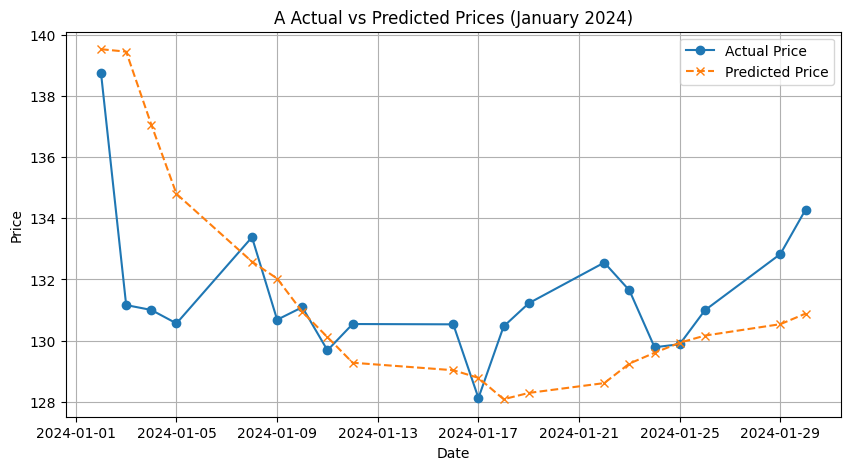

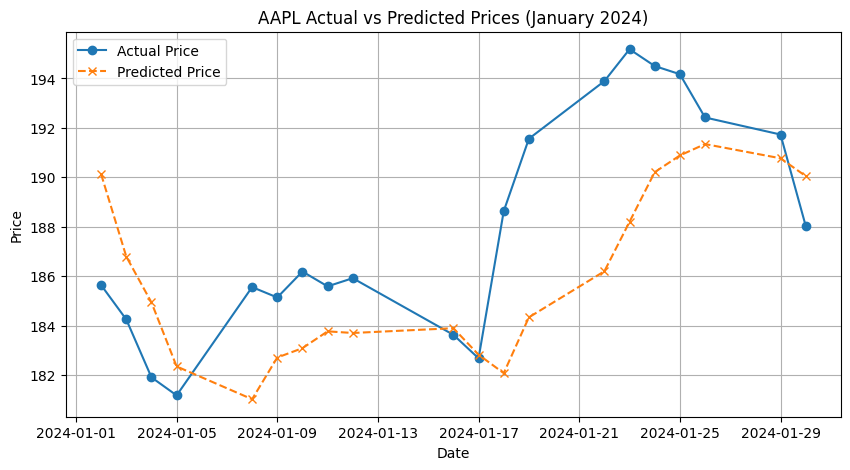

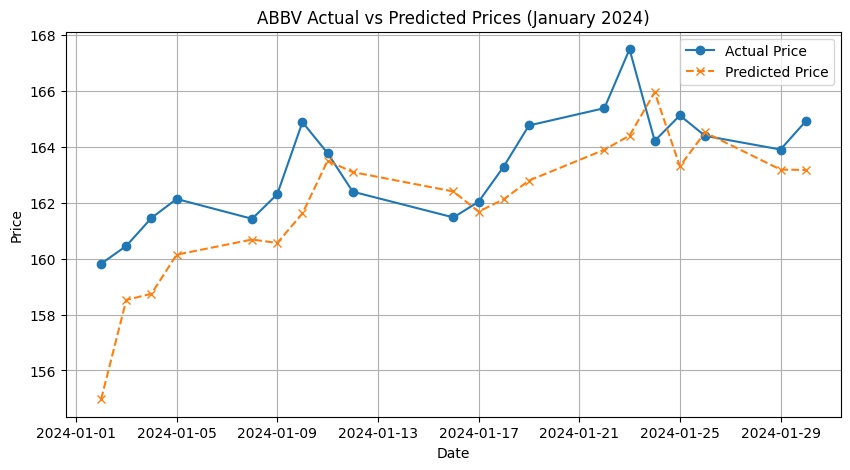

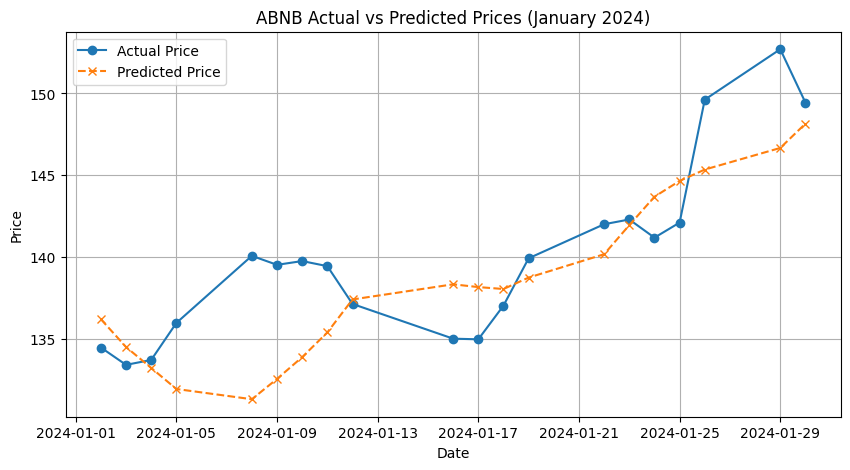

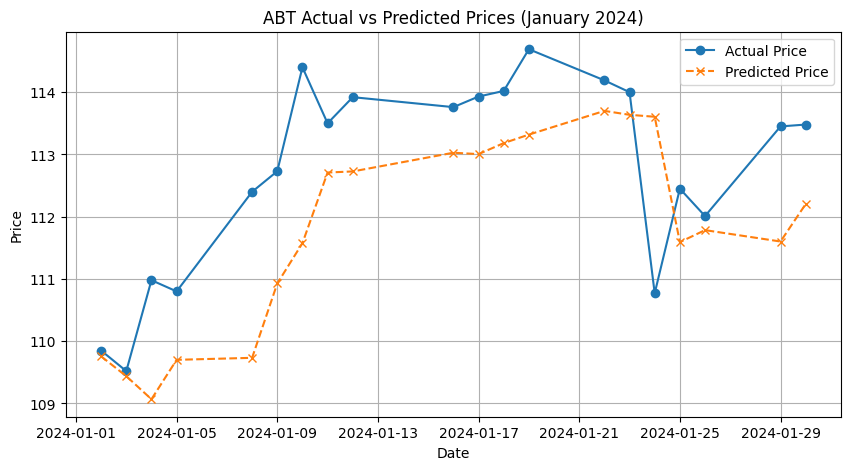

In [29]:
if all_predictions:
    for ticker in combined_preds['ticker'].unique()[:5]:
        jan_data = combined_preds[combined_preds['ticker'] == ticker].copy()
        plt.figure(figsize=(10, 5))
        plt.plot(jan_data['date'], jan_data['actual'], label='Actual Price', marker='o')
        plt.plot(jan_data['date'], jan_data['prediction'], label='Predicted Price', linestyle='--', marker='x')
        plt.title(f'{ticker} Actual vs Predicted Prices (January 2024)')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()

Evaluation Metrics for January 2024 (After Improvements):
  ticker        MAE         MSE      MAPE
0      A   3.155976   13.213771  2.400993
1   AAPL   4.921982   37.933091  2.613479
2   ABBV   1.839426    4.321811  1.127494
3   ABNB   2.895107   11.303382  2.082084
4    ABT   1.035099    2.024122  0.921022
5   ACGL   0.996182    1.547105  1.273933
6    ACN   5.336193   38.976276  1.498243
7   ADBE  11.133577  248.533150  1.903605
8    ADI   5.653893   42.676896  2.928666
9    ADM   4.023048   27.192587  6.923753

ticker        MAE         MSE      MAPE
0      A   2.510916    9.781184  1.909038
1   AAPL   3.988337   25.020044  2.123069
2   ABBV   2.204833    6.477870  1.355135
3   ABNB   3.948602   24.054881  2.792882
4    ABT   1.159850    2.314769  1.029515
5   ACGL   0.791104    0.994119  1.006567
6    ACN   7.186702   73.290444  2.048383
7   ADBE  12.013211  202.961670  2.021299
8    ADI   3.840765   26.576900  1.986539
9    ADM   4.086361   44.791132  7.491040


Evaluation Metrics for January 2024 (After Hyperparameter Tuning and More Indicators):
  ticker       MAE        MSE      MAPE
0      A  2.196139   9.201430  1.669319
1   AAPL  3.290680  15.990924  1.737128
2   ABBV  1.668323   4.068207  1.022385
3   ABNB  3.038550  14.646998  2.157283
4    ABT  1.211487   2.174685  1.073653